In [38]:
import pandas as pd
import glob
from sklearn.model_selection import train_test_split
from datasets import Dataset

In [39]:
images = glob.glob('/mnt/nas05/data01/vincenzo/ecallisto/data/*/*/*/*.png')

In [40]:
df = pd.DataFrame()

In [41]:
df['file_name'] = images
df['label'] = df['file_name'].str.split('/', expand=True)[9].astype(str)
df['antenna'] = df['file_name'].str.split('/', expand=True)[8].astype(str)
df['datetime'] = df['file_name'].str.split('/', expand=True)[10].str.replace('.png', '')
df['file_name'] = df['file_name'].str.replace('/mnt/nas05/data01/vincenzo/ecallisto/data/', '').astype(str)
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d_%H-%M-%S')#.astype('int64') // 10**9

In [42]:
df[df.label=='1']

,file_name,label,antenna,datetime
8609,test/Australia-ASSA_02/1/2021-04-22_04-38-00.png,1,Australia-ASSA_02,2021-04-22 04:38:00
16690,valid/Australia-ASSA_02/1/2021-10-10_23-11-00.png,1,Australia-ASSA_02,2021-10-10 23:11:00
66367,train/HUMAIN_59/1/2021-04-19_07-53-00.png,1,HUMAIN_59,2021-04-19 07:53:00
73844,train/AUSTRIA-UNIGRAZ_01/1/2021-04-19_07-53-00...,1,AUSTRIA-UNIGRAZ_01,2021-04-19 07:53:00
75888,train/Australia-ASSA_02/1/2021-05-08_05-06-00.png,1,Australia-ASSA_02,2021-05-08 05:06:00


In [43]:
train, val, test = df[df['file_name'].str.contains('train')],  df[df['file_name'].str.contains('valid')],  df[df['file_name'].str.contains('test')]
train['file_name'] = train['file_name'].str.replace('train/', '').astype(str)
val['file_name'] = val['file_name'].str.replace('valid/', '').astype(str)
test['file_name'] = test['file_name'].str.replace('test/', '').astype(str)

/tmp/ipykernel_1978582/2757098019.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['file_name'] = train['file_name'].str.replace('train/', '').astype(str)
/tmp/ipykernel_1978582/2757098019.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val['file_name'] = val['file_name'].str.replace('valid/', '').astype(str)
/tmp/ipykernel_1978582/2757098019.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [44]:
train.to_csv('/mnt/nas05/data01/vincenzo/ecallisto/data/train/metadata.csv', index=False)
test.to_csv('/mnt/nas05/data01/vincenzo/ecallisto/data/test/metadata.csv', index=False)
val.to_csv('/mnt/nas05/data01/vincenzo/ecallisto/data/valid/metadata.csv', index=False)

In [50]:
test

,file_name,label,antenna,datetime
18022,SWISS-Landschlacht_62/0/2022-04-29_08-21-00.png,0,SWISS-Landschlacht_62,2022-04-29 08:21:00
18023,SWISS-Landschlacht_62/0/2022-04-13_15-37-00.png,0,SWISS-Landschlacht_62,2022-04-13 15:37:00
18024,SWISS-Landschlacht_62/0/2023-10-30_09-06-00.png,0,SWISS-Landschlacht_62,2023-10-30 09:06:00
18025,SWISS-Landschlacht_62/0/2022-06-21_07-12-00.png,0,SWISS-Landschlacht_62,2022-06-21 07:12:00
18026,SWISS-Landschlacht_62/0/2022-11-18_12-26-00.png,0,SWISS-Landschlacht_62,2022-11-18 12:26:00
...,...,...,...,...
90138,TRIEST_57/4/2022-10-04_13-06-00.png,4,TRIEST_57,2022-10-04 13:06:00
90139,TRIEST_57/4/2023-05-04_09-20-00.png,4,TRIEST_57,2023-05-04 09:20:00
90140,TRIEST_57/4/2023-05-05_07-52-00.png,4,TRIEST_57,2023-05-05 07:52:00
90141,TRIEST_57/4/2024-02-09_13-15-00.png,4,TRIEST_57,2024-02-09 13:15:00


/tmp/ipykernel_1978582/2970711289.py:10: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  date_range_per_antenna = test.groupby('antenna')['datetime'].agg([min, max])
/tmp/ipykernel_1978582/2970711289.py:10: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  date_range_per_antenna = test.groupby('antenna')['datetime'].agg([min, max])


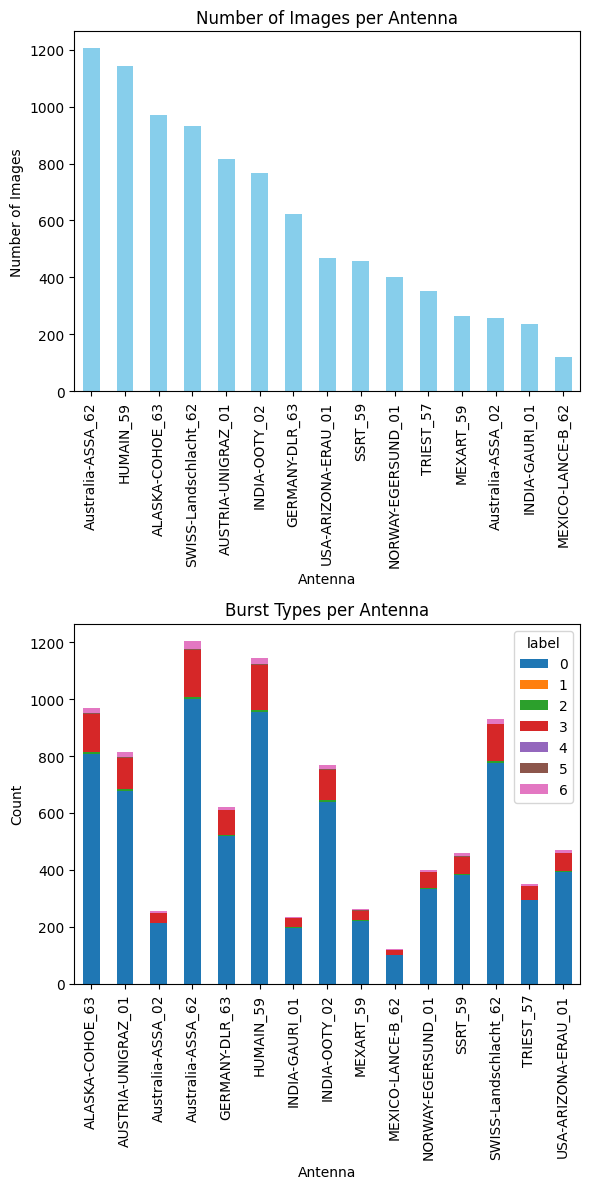

In [51]:
# EDA
import matplotlib.pyplot as plt
# Number of images per antenna
images_per_antenna = test['antenna'].value_counts()

# Number of burst types per antenna
burst_types_per_antenna = test.groupby('antenna')['label'].value_counts().unstack(fill_value=0)

# Date range per antenna
date_range_per_antenna = test.groupby('antenna')['datetime'].agg([min, max])

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(6, 12))

# Images per antenna
images_per_antenna.plot(kind='bar', ax=ax[0], color='skyblue')
ax[0].set_title('Number of Images per Antenna')
ax[0].set_xlabel('Antenna')
ax[0].set_ylabel('Number of Images')

# Burst types per antenna
burst_types_per_antenna.plot(kind='bar', stacked=True, ax=ax[1])
ax[1].set_title('Burst Types per Antenna')
ax[1].set_xlabel('Antenna')
ax[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [28]:
from datasets import load_dataset
test = load_dataset('imagefolder', data_dir='/mnt/nas05/data01/vincenzo/ecallisto/data/test')
valid = load_dataset('imagefolder', data_dir='/mnt/nas05/data01/vincenzo/ecallisto/data/valid')
train = load_dataset('imagefolder', data_dir='/mnt/nas05/data01/vincenzo/ecallisto/data/train')

Generating train split: 9011 examples [00:04, 1905.44 examples/s]
Generating train split: 9011 examples [00:04, 1891.74 examples/s]
Generating train split: 72121 examples [00:41, 1754.39 examples/s]


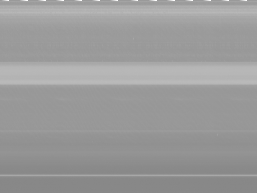

In [29]:
valid['train']['image'][0]

In [30]:
from datasets import DatasetDict
dd = DatasetDict({"train": train['train'],"validation": valid['train'], "test":test['train']})

In [31]:
dd.push_to_hub('i4ds/radio-sunburst-ecallisto')

Uploading the dataset shards: 100%|██████████| 1/1 [00:46<00:00, 46.95s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/i4ds/radio-sunburst-ecallisto/commit/6df36a7133c2bfb018d84793e24711ef0d12c443', commit_message='Upload dataset', commit_description='', oid='6df36a7133c2bfb018d84793e24711ef0d12c443', pr_url=None, pr_revision=None, pr_num=None)

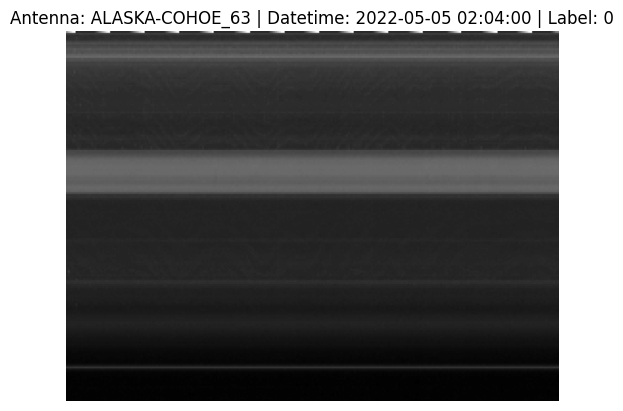

In [32]:
# Display the image
plt.imshow(dd['train']['image'][300], cmap='gray')  # 'gray' colormap for mode=L (grayscale)
plt.title(f"Antenna: {dd['train']['antenna'][300]} | Datetime: {dd['train']['datetime'][300]} | Label: {dd['train']['label'][300]}")
plt.axis('off')  # Turn off the axis
plt.show()